In [1]:
!nvidia-smi

Thu Jul 23 10:16:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   27C    P8    36W / 280W |    742MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 41%   32C    P8    22W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
#transformation for Images 

data_transform = transforms.Compose([   transforms.Scale((229,213)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
                                            ])

#CUSTOM DATASET CREATION FROM .csv file
class Customdataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=data_transform):

        self.img_pair = pd.read_csv(txt_file, sep=",", engine='python', header=None, error_bad_lines=False)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_pair)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_x = os.path.join(self.root_dir,
                                self.img_pair.iloc[idx, 0])
        image_x = Image.open(img_x)

        img_y = os.path.join(self.root_dir,
                                self.img_pair.iloc[idx, 1])
        image_y = Image.open(img_y)

        label=int(self.img_pair.iloc[idx, 2])

        if self.transform:
            image_x_t = self.transform(image_x)
            image_y_t = self.transform(image_y)
            


        return image_x_t,image_y_t,label



/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


**Model Architecture**


_We Return the embeddings from the second last layer in the forward pass_

In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [6]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [7]:
class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



In [8]:
# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes= 3714, zero_init_residual=False,
#                  groups=1, width_per_group=64, replace_stride_with_dilation=None,
#                  norm_layer=None):
#         super(ResNet, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         self._norm_layer = norm_layer

#         self.inplanes = 64
#         self.dilation = 1
#         if replace_stride_with_dilation is None:
#             # each element in the tuple indicates if we should replace
#             # the 2x2 stride with a dilated convolution instead
#             replace_stride_with_dilation = [False, False, False]
#         if len(replace_stride_with_dilation) != 3:
#             raise ValueError("replace_stride_with_dilation should be None "
#                              "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
#         self.groups = groups
#         self.base_width = width_per_group
#         self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
#                                        dilate=replace_stride_with_dilation[0])
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
#                                        dilate=replace_stride_with_dilation[1])
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
#                                        dilate=replace_stride_with_dilation[2])
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

#     def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
#         norm_layer = self._norm_layer
#         downsample = None
#         previous_dilation = self.dilation
#         if dilate:
#             self.dilation *= stride
#             stride = 1
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
#                             self.base_width, previous_dilation, norm_layer))
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes, groups=self.groups,
#                                 base_width=self.base_width, dilation=self.dilation,
#                                 norm_layer=norm_layer))

#         return nn.Sequential(*layers)

    

#     def _forward_impl(self, x):
                
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)

#         ##The embedding which will be used for cosine similarity
#         embedding = torch.flatten(x, 1)

        
# #         x= self.fc(embedding)
# #         x1 = self.fc1(x)
# #         x = x/torch.norm(self.fc.weight, dim=1)
        
#         return embedding

#     def forward(self, x):
#         return self._forward_impl(x)

    
import torch.nn as nn
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes, bottleneck=False):
        super(ResNet, self).__init__()        
        
        
        blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
        layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
        assert layers[depth], 'invalid detph for ResNet (depth should be one of 18, 34, 50, 101, 152, and 200)'

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(blocks[depth], 64, layers[depth][0])
        self.layer2 = self._make_layer(blocks[depth], 128, layers[depth][1], stride=2)
        self.layer3 = self._make_layer(blocks[depth], 256, layers[depth][2], stride=2)
        self.layer4 = self._make_layer(blocks[depth], 512, layers[depth][3], stride=2)
        self.avgpool = nn.AvgPool2d(7) 
        self.fc = nn.Linear(512 * blocks[depth].expansion, num_classes)
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            
            ## ResNet-D modification, add Average pool before conv in Path-b of Downsampling block; change stride of conv to 1
            if stride == 1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                     kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )
            else:
                downsample = nn.Sequential(
                    nn.AvgPool2d(stride),
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                     kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        embedding = x.view(x.size(0), -1)
#         x = self.fc(x)        
        
        return embedding

        


**Load the model from checkpoint to run Testing on**

In [9]:
# model = ResNet(Bottleneck, [3,4,6,3])
model = ResNet(depth = 50, num_classes = 3714)

checkpoint = torch.load('saved_model_checkpoints/Resnet_D_cutmix_Toys_Median_Ringloss')


model = nn.DataParallel(model,device_ids=[0,1,2,3]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [10]:
# model = ResNet(Bottleneck, [3,4,6,3])

# # Transfer Learning

# fc_inputs = model.fc.in_features

# model.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 4096),
#     nn.BatchNorm1d(4096),
#     nn.ReLU(),
#     nn.Linear(4096, 3714)
    
# )

# # checkpoint = torch.load('saved_model_checkpoints/Finetune_best_v1')
# # checkpoint = torch.load('saved_model_checkpoints/Finetune_best_v1_ringloss')
# checkpoint = torch.load('saved_model_checkpoints/Finetune_best_v1_ringloss_relu')


# model = nn.DataParallel(model,device_ids=[4,5,6,7]).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])

# model

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model_checkpoints/Finetune_best_v1_ringloss_relu'

**Using Cosine Similarity to evaluate the performance of the classifier in the Open set**

In [10]:
def predict_score(model, image_1, image_2, threshold):
    
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    scores=[]
    matches_at_threshold = [[] for i in threshold]
        
    embeddings_1 = model(image_1)
    embeddings_2 = model(image_2)


    for i in range(len(embeddings_1)):         
        scores.append(cos(embeddings_1[i].detach().cpu(), embeddings_2[i].detach().cpu()).numpy())
        
    for i in range(len(threshold)):

        for score in scores:
            if score>threshold[i]:
                matches_at_threshold[i].append(1)
            else:
                matches_at_threshold[i].append(0)
            
    return [torch.as_tensor(m) for m in matches_at_threshold] 

In [13]:
root_dir = '/media/Cygnus/Panos_pull_azure/upc_crops_sec_run_depts/merged_selected_6_depts/'
test_pairwise_path='/home/sreena/pairwise_val_dept7.txt'

# Dataloader
test_dataset=Customdataset(test_pairwise_path,root_dir)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle = True, num_workers=16)


model.eval()

# threshold = [0.4, 0.45, 0.48,0.49, 0.5, 0.51,0.52, 0.55,0.6]
threshold = np.arange(0.4,0.61,0.01)
correctHits = [0 for i in threshold]

#Experiments(use one at a time)
# Baseline_Accuracy = []
# cutmix_Toys_Median =[]
# Finetune_v1_model =[]
# label_smoothing = []
# cutmix_Toys_Median_Ringloss = []
# Finetune_best_v1_ringloss = []
Finetune_best_v1_ringloss_ReLU = []

for batch_id, [image_1,image_2,is_match] in enumerate(test_dataloader):


    image_1, image_2 = image_1.to(device), image_2.to(device)

    matches_at_threshold = predict_score(model,image_1, image_2, threshold)

    for i in range(len(matches_at_threshold)):
        
        correctHits[i] += (matches_at_threshold[i] == is_match).sum()

for i in range(len(correctHits)):
    acc = 100*(correctHits[i].item()/len(test_dataloader.dataset))
    Finetune_best_v1_ringloss_ReLU.append( acc )


**Plotting Accuracies for different thresholds for various experiments** 

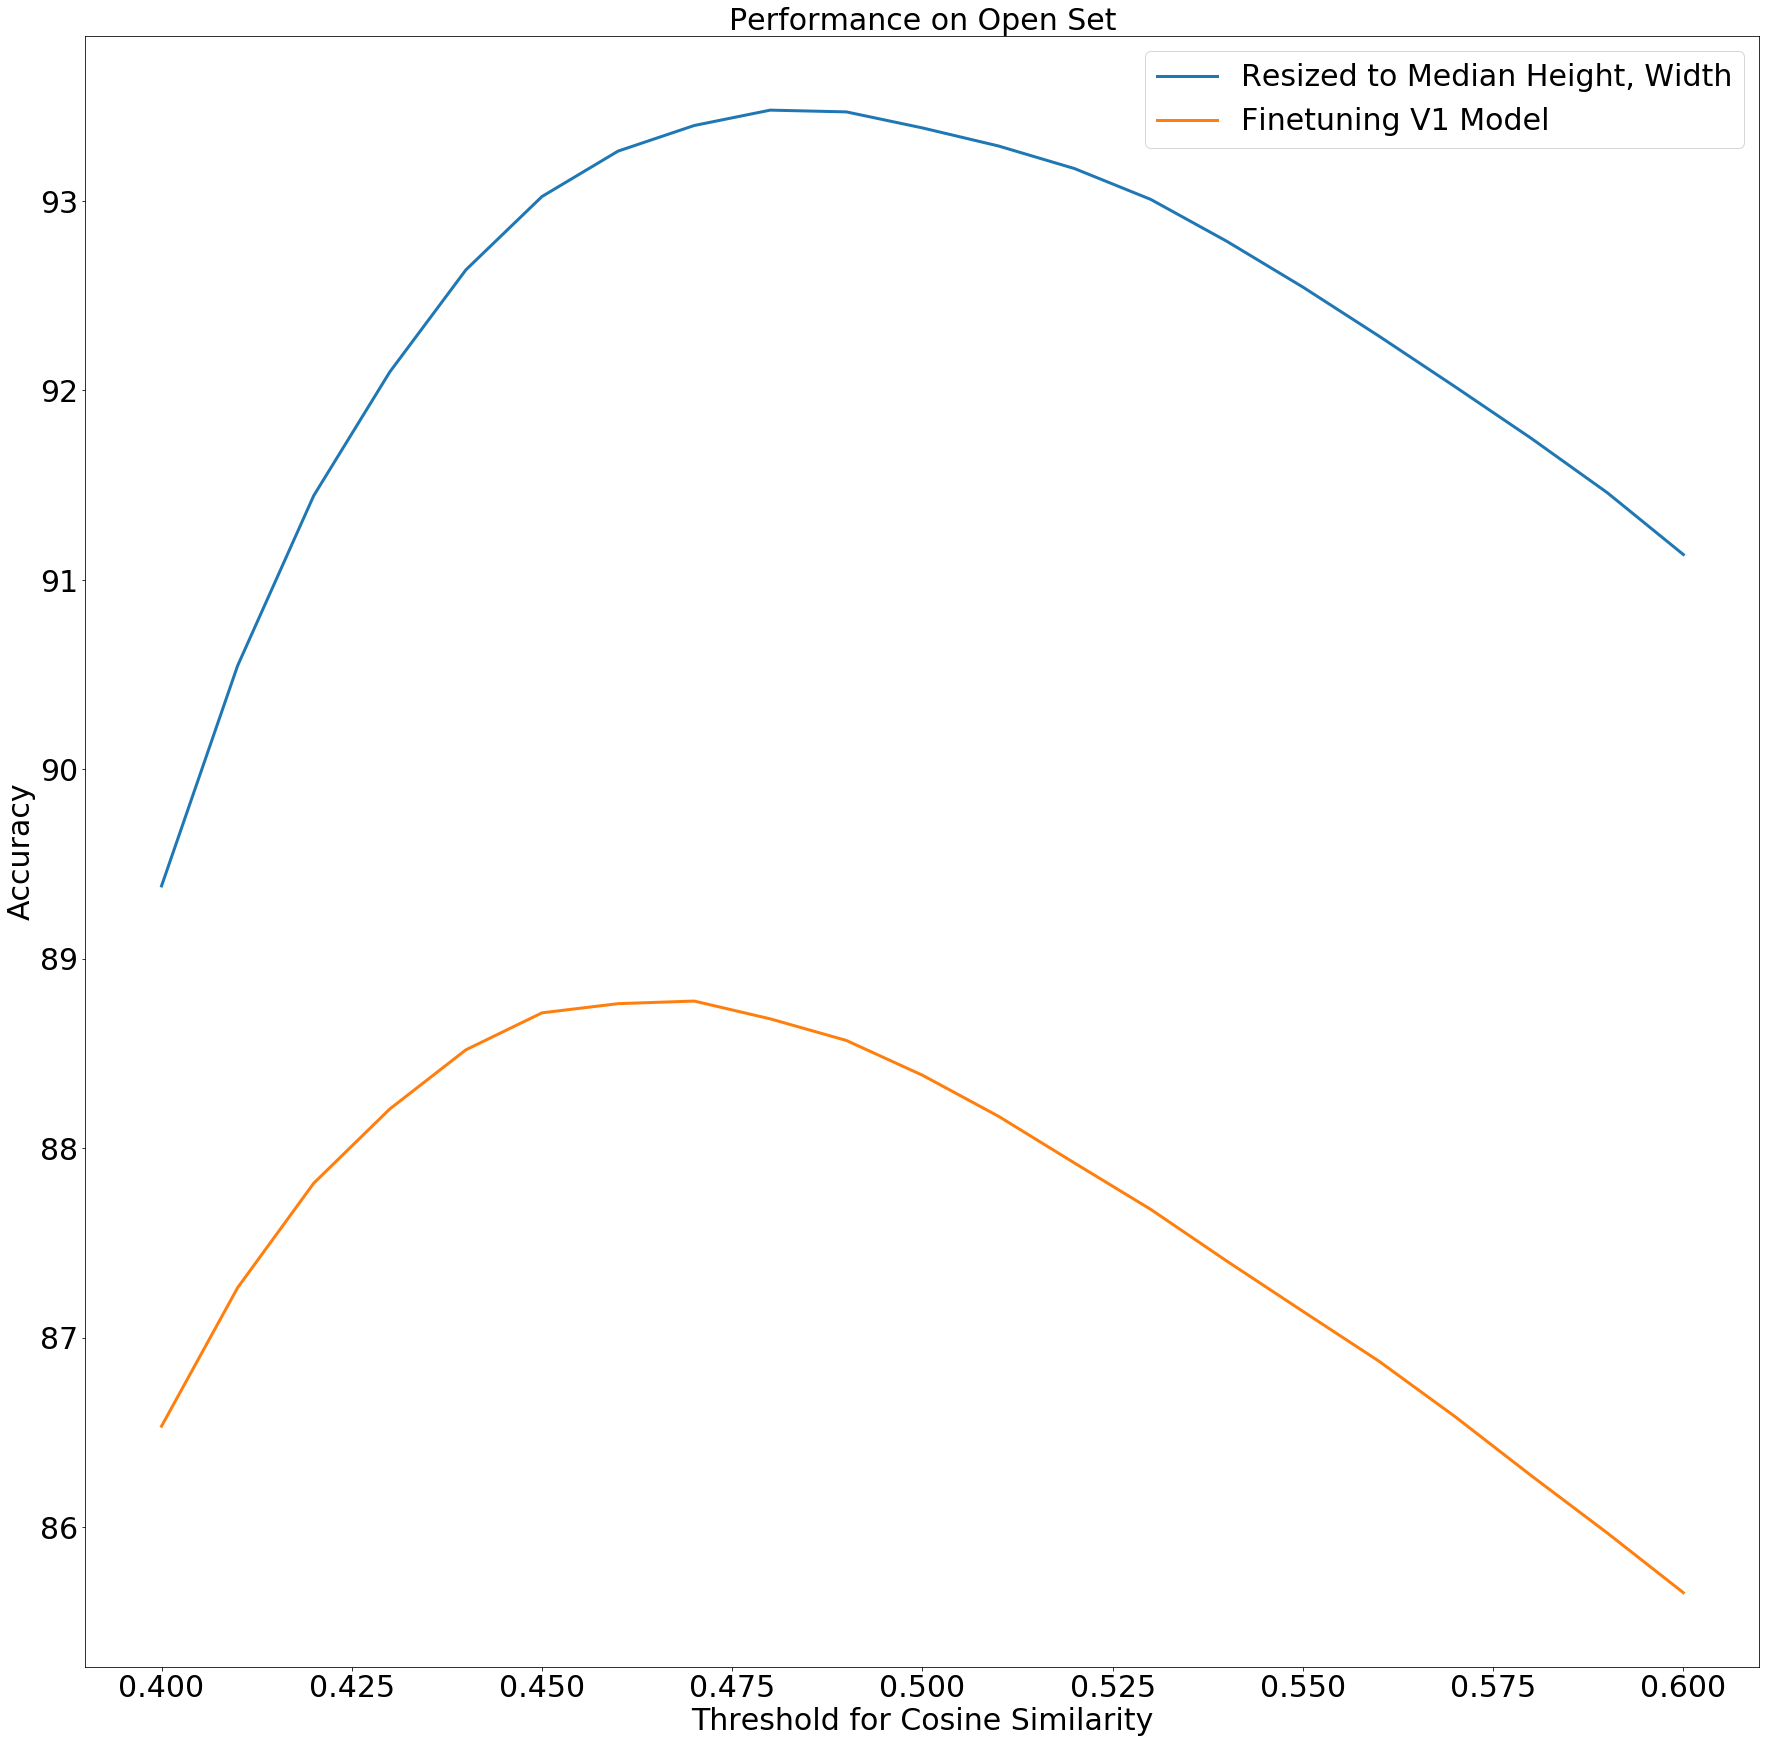

In [20]:
plt.figure(figsize=(30,30))
Threshold = np.arange(0.4,0.61,0.01)

plt.plot(Threshold, cutmix_Toys_Median, label = 'Resized to Median Height, Width', linewidth = 3)
plt.plot(Threshold, Finetune_v1_model, label = 'Finetuning V1 Model', linewidth = 3)
# plt.plot(Threshold, Cutmix_from_Baseline_26epochs_Accuracy, label = 'Cutmix Regularization',linewidth = 3)
# plt.plot(Threshold, mixup_model_Accuracy, label = 'Mixup', linewidth = 3)
# plt.plot(Threshold, CosineLR_Accuracy, label = 'Cosine Learning Rate Decay', linewidth = 3)
# plt.plot(Threshold, Baseline_Accuracy, label = 'Baseline Model - ResNet50', linewidth = 5, linestyle='--')

plt.xticks(fontsize = 30)
plt.yticks(fontsize= 30)

plt.xlabel('Threshold for Cosine Similarity', fontsize = 30)
plt.ylabel('Accuracy', fontsize = 30)
plt.title('Performance on Open Set',fontsize = 30)
plt.legend(fontsize=30)

In [17]:
Finetune_v1_model = [86.53226003767954,
 87.26334075505859,
 87.81483203249248,
 88.20679699542463,
 88.51899880110592,
 88.71424726578748,
 88.76269237356561,
 88.77639402020992,
 88.68243987179173,
 88.56842259793008,
 88.38491840180079,
 88.16813877810674,
 87.92101979398595,
 87.67683687700325,
 87.40378263316288,
 87.13855790169069,
 86.87529054831053,
 86.5826625235497,
 86.27143940691444,
 85.96853514717037,
 85.65339727435101]

[86.53226003767954,
 87.26334075505859,
 87.81483203249248,
 88.20679699542463,
 88.51899880110592,
 88.71424726578748,
 88.76269237356561,
 88.77639402020992,
 88.68243987179173,
 88.56842259793008,
 88.38491840180079,
 88.16813877810674,
 87.92101979398595,
 87.67683687700325,
 87.40378263316288,
 87.13855790169069,
 86.87529054831053,
 86.5826625235497,
 86.27143940691444,
 85.96853514717037,
 85.65339727435101]

In [19]:
cutmix_Toys_Median = [89.38415991779011,
 90.54684250446526,
 91.44430035966823,
 92.09757529788848,
 92.63634361772407,
 93.0234151354261,
 93.2631939517017,
 93.39825304005285,
 93.47948423087274,
 93.47018668493553,
 93.38553008245455,
 93.29010790046732,
 93.17070783685254,
 93.00824545521274,
 92.78706173081159,
 92.54532553644394,
 92.28646228377089,
 92.01928017420666,
 91.74720461941229,
 91.45995938440458,
 91.13356658755598]


In [14]:
Finetune_best_v1_ringloss_ReLU

[86.88703481686281,
 87.49186464730494,
 87.95135915441267,
 88.33696263854567,
 88.56010374103887,
 88.69565217391305,
 88.73920383646106,
 88.70592840889628,
 88.63497345305963,
 88.50382912089256,
 88.31836754667124,
 88.13143793888088,
 87.88187223214504,
 87.64845489466859,
 87.39008098651856,
 87.09989968437279,
 86.8346749529006,
 86.53764282743266,
 86.2440361136258,
 85.92645151819139,
 85.62648332558538]

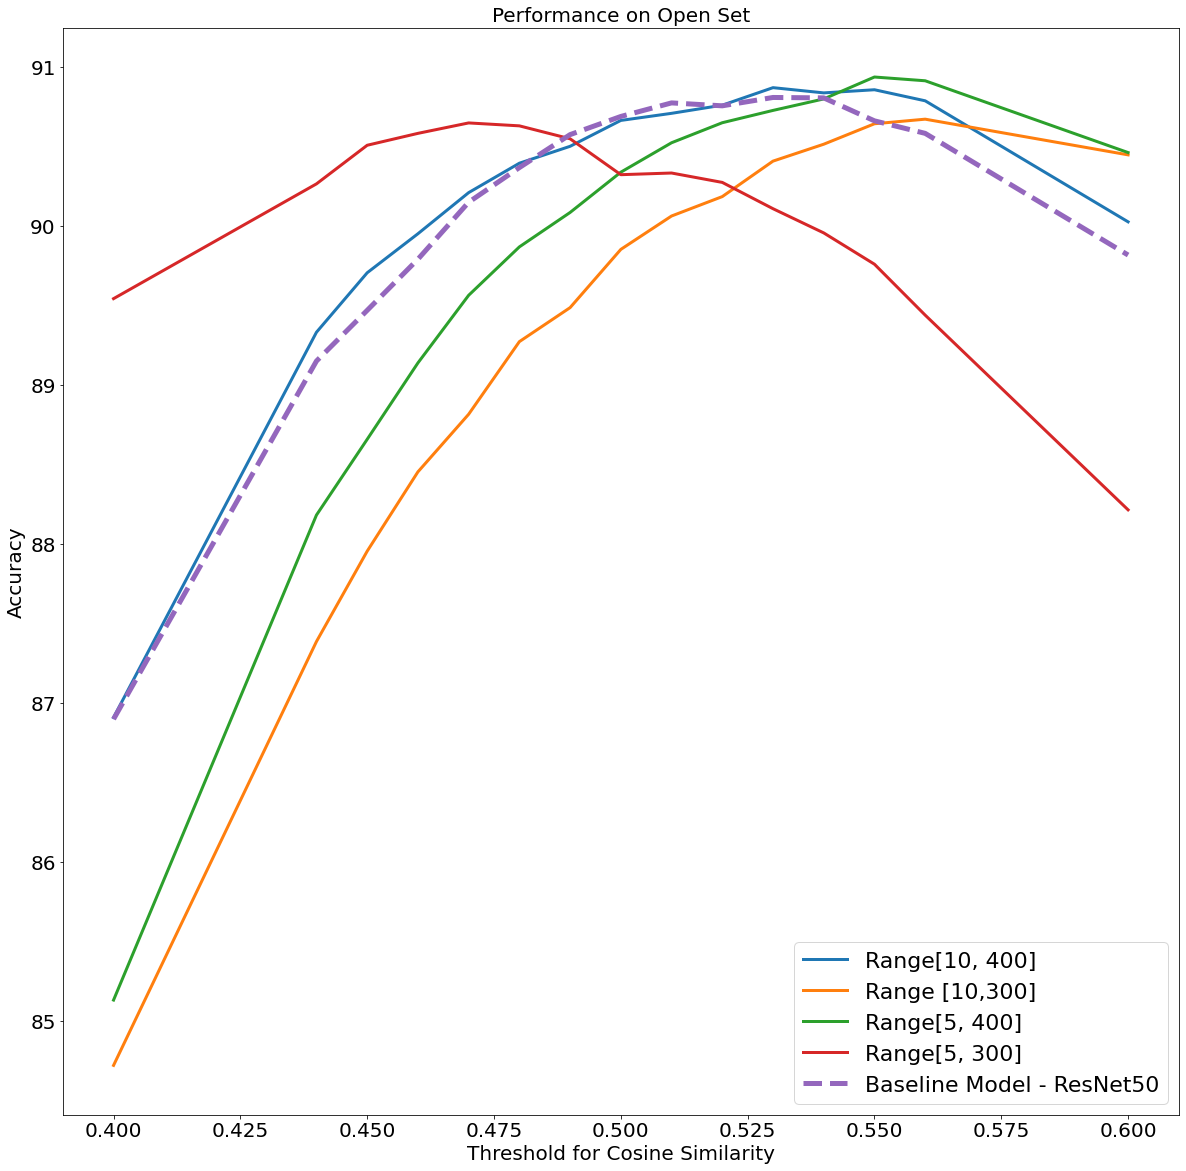

In [10]:
plt.figure(figsize=(20,20))
Threshold = np.arange(0.4,0.61,0.01)

plt.plot(Threshold, Long_Tail_10_400, label = 'Range[10, 400]',linewidth = 3)
plt.plot(Threshold, Long_Tail_10_300, label = 'Range [10,300]',linewidth = 3)
plt.plot(Threshold, Long_Tail_5_400, label = 'Range[5, 400]',linewidth = 3)
plt.plot(Threshold, Long_Tail_5_300, label = 'Range[5, 300]',linewidth = 3)

plt.plot(Threshold, Baseline_Accuracy, label = 'Baseline Model - ResNet50', linewidth = 5, linestyle='--')

plt.xticks(fontsize = 20)
plt.yticks(fontsize= 20)

plt.xlabel('Threshold for Cosine Similarity', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title('Performance on Open Set',fontsize = 20)
plt.legend(fontsize=22)

In [13]:
label_smoothing = [58.06121699982872,
 63.23407795258251,
 68.051185437107,
 72.46800910180812,
 76.359276748795,
 79.82089990457781,
 82.78877443664211,
 85.22179540505493,
 87.16742922854836,
 88.65405788945708,
 89.7604658559859,
 90.5223752783147,
 91.05918622005824,
 91.37628147096963,
 91.56565780137505,
 91.57984879254238,
 91.47023561938784,
 91.28330601159746,
 91.04890998507499,
 90.74258031366983,
 90.41765555039025]


[58.06121699982872,
 63.23407795258251,
 68.051185437107,
 72.46800910180812,
 76.359276748795,
 79.82089990457781,
 82.78877443664211,
 85.22179540505493,
 87.16742922854836,
 88.65405788945708,
 89.7604658559859,
 90.5223752783147,
 91.05918622005824,
 91.37628147096963,
 91.56565780137505,
 91.57984879254238,
 91.47023561938784,
 91.28330601159746,
 91.04890998507499,
 90.74258031366983,
 90.41765555039025]

In [12]:
Finetune_best_v1_ringloss = [86.63453304298892,
 87.32793423209611,
 87.85349024981038,
 88.25181669154169,
 88.50872256612267,
 88.64622837708889,
 88.73822514741504,
 88.72305546720169,
 88.66580215800934,
 88.52389224633603,
 88.36974872158744,
 88.16862812262973,
 87.92199848303198,
 87.68124097771036,
 87.41993100242226,
 87.12926035575347,
 86.85229135572901,
 86.56259939810623,
 86.27192875143746,
 85.96657776907833,
 85.63382349343055]

[86.63453304298892,
 87.32793423209611,
 87.85349024981038,
 88.25181669154169,
 88.50872256612267,
 88.64622837708889,
 88.73822514741504,
 88.72305546720169,
 88.66580215800934,
 88.52389224633603,
 88.36974872158744,
 88.16862812262973,
 87.92199848303198,
 87.68124097771036,
 87.41993100242226,
 87.12926035575347,
 86.85229135572901,
 86.56259939810623,
 86.27192875143746,
 85.96657776907833,
 85.63382349343055]

In [12]:
cutmix_Toys_Median_Ringloss = [93.98595581218957,
 94.20273543588364,
 94.35198551540212,
 94.44496097477429,
 94.47334295710895,
 94.46893885640185,
 94.42489784933082,
 94.35687896063223,
 94.2443297203396,
 94.13031244647794,
 93.96687137579212,
 93.82642949768784,
 93.67522204007732,
 93.49758997822417,
 93.31359643757187,
 93.11834797289032,
 92.91918475202466,
 92.71170267426781,
 92.47241320251524,
 92.22627290744049,
 91.98894081377993]

[93.98595581218957,
 94.20273543588364,
 94.35198551540212,
 94.44496097477429,
 94.47334295710895,
 94.46893885640185,
 94.42489784933082,
 94.35687896063223,
 94.2443297203396,
 94.13031244647794,
 93.96687137579212,
 93.82642949768784,
 93.67522204007732,
 93.49758997822417,
 93.31359643757187,
 93.11834797289032,
 92.91918475202466,
 92.71170267426781,
 92.47241320251524,
 92.22627290744049,
 91.98894081377993]